

#  Twitter Sentiment Analysis: Combining IBM Watson with Advanced Analytics 



<img src="https://snag.gy/RNAEgP.jpg" width="600">

Can we correctly identify which of these two tweeted what?


## Objective : Classify Whether a Tweet Comes from Trump, or Sanders

- Pull a list of tweets from Twitter

--Data Pipeline:
- Perform proper preprocessing using Spark & Watson Tone Analyzer
- Use Data Science Experience and Watson Personality Insights to Process Data
- Data Vizualization

## Install Python Twitter API library & Watson Developer Cloud

In [69]:
!pip install twitter python-twitter
!pip install --user watson-developer-cloud
!pip install --upgrade --user pixiedust

Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s0e2-2229468d893d94-ac4cd83694d3/.local/lib/python2.7/site-packages
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s0e2-2229468d893d94-ac4cd83694d3/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s0e2-2229468d893d94-ac4cd83694d3/.local/lib/python2.7/site-packages (from pixiedust)
Batch completed with 151 records
Batch started with 177 records


## Install the streaming Twitter jar in the notebook from the Github repo

In [70]:
import pixiedust
jarPath = "https://github.com/ibm-cds-labs/spark.samples/raw/master/dist/streaming-twitter-assembly-1.6.jar"
pixiedust.installPackage(jarPath)
print("done")

Package already installed: https://github.com/ibm-cds-labs/spark.samples/raw/master/dist/streaming-twitter-assembly-1.6.jar
done


## Use Scala Bridge to run the command line version of the app¶


In [71]:
import pixiedust

sqlContext=SQLContext(sc)

#Set up the twitter credentials, they will be used both in scala and python cells below
consumerKey = "g0EXNI4DVJTxmlAKzMiqEGKgi"
consumerSecret = "TSpkjqxGxuR9cLAh2h7CusVYxmJ5SG6eLE7f0RUs6MUUbcN6qT"
accessToken = "1599677424-SId5x6I6evEbraG3qFs8GuNzPqrzAnc4PbtjcKb"
accessTokenSecret = "369avxzU45YOF9cynXfpnd7ISQXOqXZnT9wYFyZtKZLhz"

#Set up the Watson Personality insight credentials
piUserName = "5447d9c5-f882-4d03-80cc-77619d4e2536"
piPassword = "DbK0lo7KRMHY"

#Set up the Watson Tone Analyzer credentials
taUserName = "0ffe4864-d94f-48f8-87b3-b5fdfdb520a0"
taPassword = "EsdQIZACnwIV"

In [72]:
%%scala
val demo = com.ibm.cds.spark.samples.StreamingTwitter
demo.setConfig("twitter4j.oauth.consumerKey",consumerKey)
demo.setConfig("twitter4j.oauth.consumerSecret",consumerSecret)
demo.setConfig("twitter4j.oauth.accessToken",accessToken)
demo.setConfig("twitter4j.oauth.accessTokenSecret",accessTokenSecret)
demo.setConfig("watson.tone.url","https://gateway.watsonplatform.net/tone-analyzer/api")
demo.setConfig("watson.tone.password",taPassword)
demo.setConfig("watson.tone.username",taUserName)

import org.apache.spark.streaming._
demo.startTwitterStreaming(sc, Seconds(30))  //Run the application for a limited time

Stopping Twitter stream. Please wait this may take a while
Receiver Stopped: TwitterReceiver-0
Reason:  : Stopped by driver
Twitter stream stopped
Starting twitter stream
Twitter stream started
Tweets are collected real-time and analyzed
To stop the streaming and start interacting with the data use: StreamingTwitter.stopTwitterStreaming


## Create a tweets dataframe from the data fetched above and transfer it to Python


In [74]:
%%scala
val demo = com.ibm.cds.spark.samples.StreamingTwitter
val (__sqlContext, __df) = demo.createTwitterDataFrames(sc)

Batch completed with 150 records
Batch started with 174 records
A new table named tweets with 62 records has been correctly created and can be accessed through the SQLContext variable
Here's the schema for tweets
root
 |-- author: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- date: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- text: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- Anger: double (nullable = true)
 |-- Disgust: double (nullable = true)
 |-- Fear: double (nullable = true)
 |-- Joy: double (nullable = true)
 |-- Sadness: double (nullable = true)
 |-- Analytical: double (nullable = true)
 |-- Confident: double (nullable = true)
 |-- Tentative: double (nullable = true)
 |-- Openness: double (nullable = true)
 |-- Conscientiousness: double (nullable = true)
 |-- Extraversion: double (nullable = true)
 |-- Agreeableness: double (nullable = true)
 |-- EmotionalRange: double (nullable =

## Group the tweets by author and userid

In [75]:
import pyspark.sql.functions as F
usersDF = __df.groupby("author", "userid").agg(F.avg("Anger").alias("Anger"), F.avg("Disgust").alias("Disgust"))
usersDF.show()

+--------------------+---------------+------------------+-----------------+
|              author|         userid|             Anger|          Disgust|
+--------------------+---------------+------------------+-----------------+
|           Nanad 나디야|        nanadC1|14.000000000000002|              2.0|
|     Cassandra Lopez| Cassielopez010|               2.0|             18.0|
|    Room Rent Jaipur|RoomRentJaipur1|               8.0|              5.0|
|             Cikbell|  Nabilasuhada1| 7.000000000000001|              6.0|
|       Hemant Pathak|   hemantbhavya|               0.0|              0.0|
|               James|       JamesJNh|               9.0|7.000000000000001|
|                   ㅤ|    barackxbama|               5.0|             10.0|
|       Martina Pizzo| Martinaa_Pizzo|               5.0|             11.0|
|          k/alie 💕✨|     pentaegith| 7.000000000000001|              5.0|
|Citipati Lin'dira'na|        Elphrat|              10.0|              3.0|
|  Kindly fol

## Set up the Twitter API from python-twitter module

## Compare Twitter users Personality Insights scores with Trump and Bernie

In [155]:
candidates = "realDonaldTrump BernieSanders".split(" ")
candidatesRDD = sc.parallelize(candidates)\
    .flatMap(lambda s: [(t.user.screen_name, t.text.encode('ascii', 'ignore')) for t in getTweets(s)])\
    .map(lambda s: (s[0], s[1]))\
    .reduceByKey(lambda s,t: s + '\n' + t)\
    .filter(lambda s: len(re.findall(r'\w+', s[1])) > 100 )\
    .map(lambda s: [s[0]] + getPersonalityInsight(s[1]))

candidatesPIDF = sqlContext.createDataFrame(
   candidatesRDD, schema
)

In [156]:
c = candidatesPIDF.collect()
broadCastTrumpPI = sc.broadcast(c[0][1:])
broadCastBerniePI = sc.broadcast(c[1][1:])


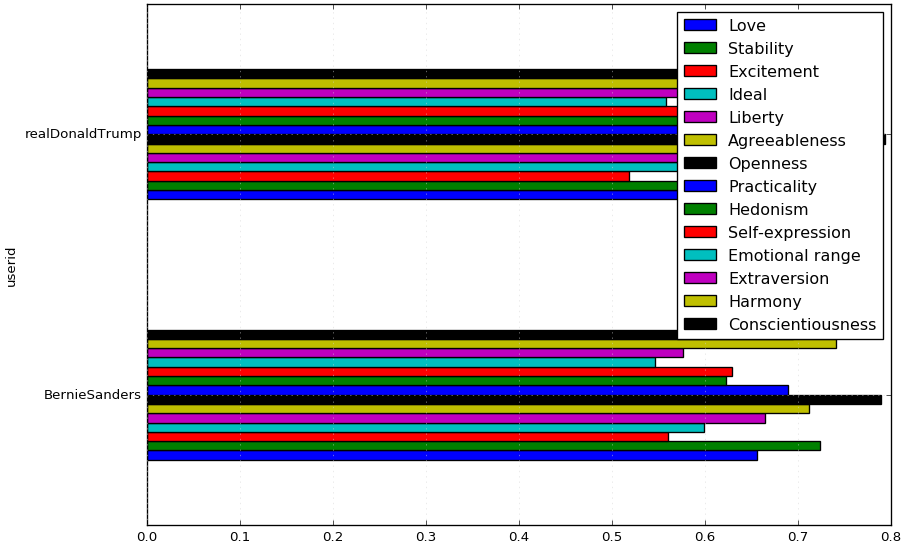


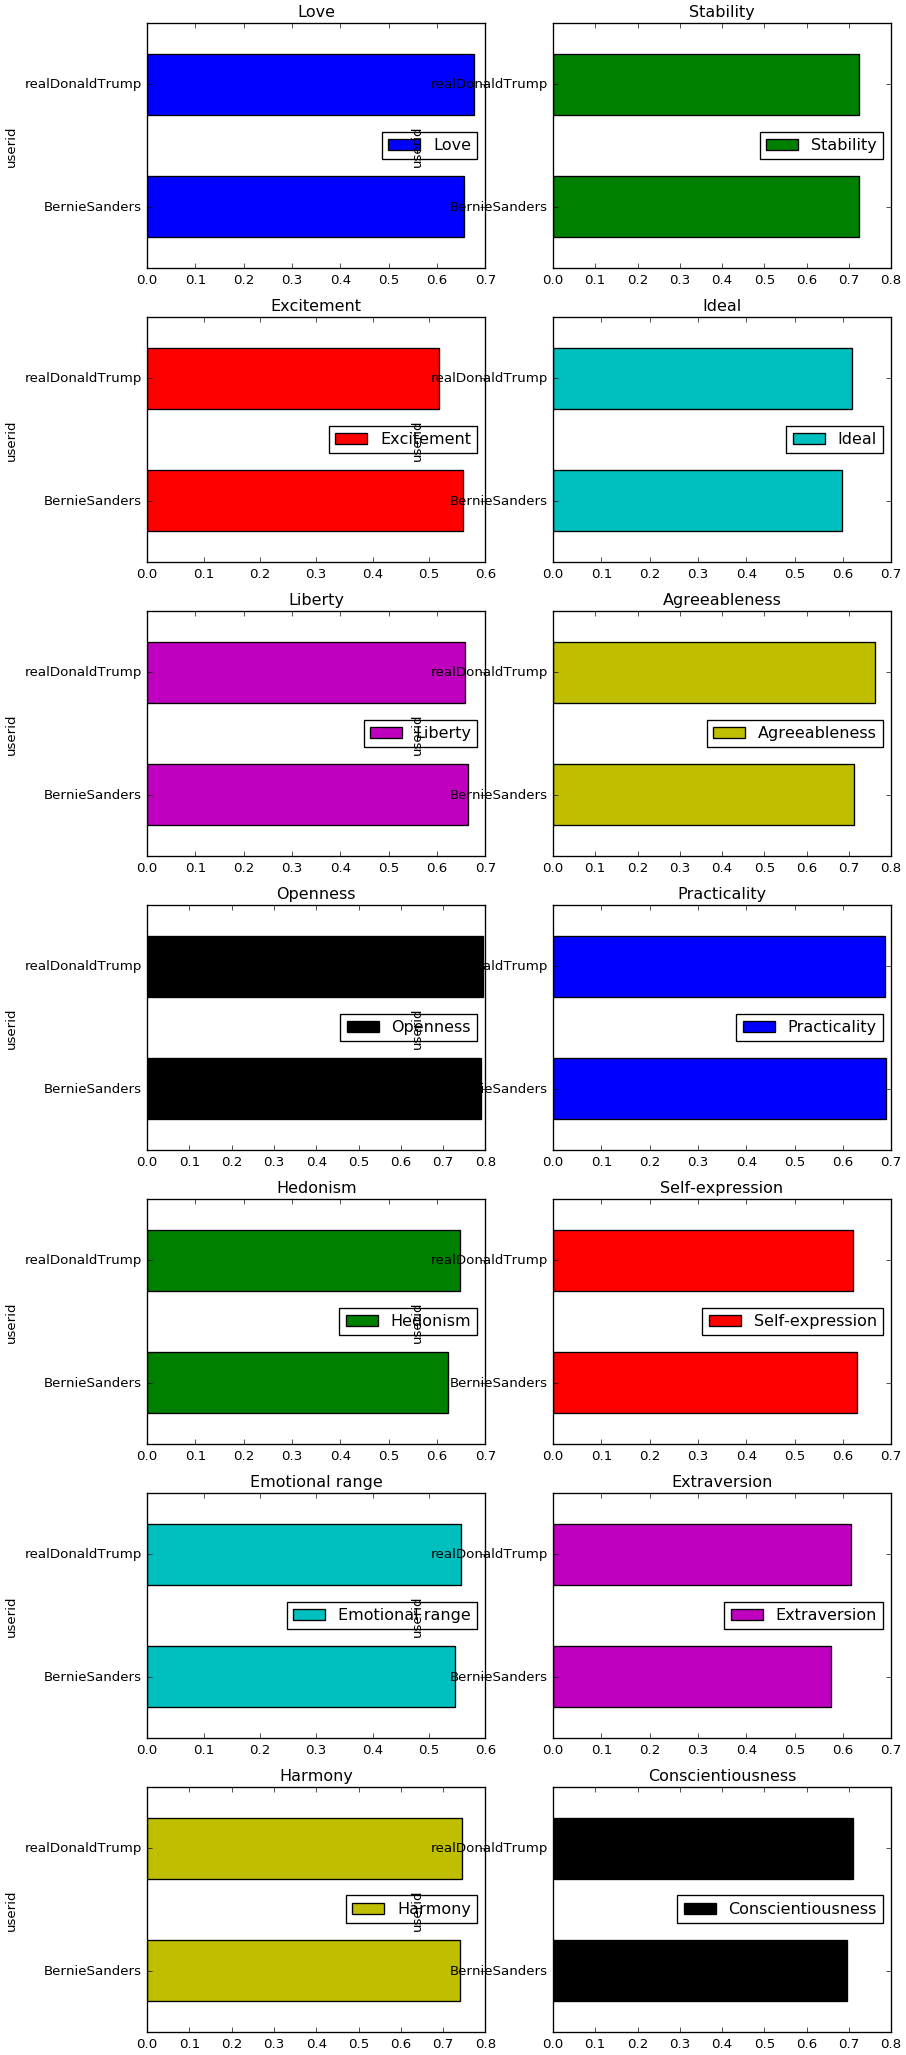

In [157]:
display(candidatesPIDF)

In [158]:
candidatesPIDF.select('userid','Emotional range','Agreeableness', 'Extraversion','Conscientiousness', 'Openness').show()

usersWithPIDF.describe(['Emotional range']).show()
usersWithPIDF.describe(['Agreeableness']).show()
usersWithPIDF.describe(['Extraversion']).show()
usersWithPIDF.describe(['Conscientiousness']).show()
usersWithPIDF.describe(['Openness']).show()

+---------------+---------------+-------------+------------+-----------------+---------+
|         userid|Emotional range|Agreeableness|Extraversion|Conscientiousness| Openness|
+---------------+---------------+-------------+------------+-----------------+---------+
|  BernieSanders|     0.54601616|    0.7116017|   0.5760583|       0.69457287|0.7894736|
|realDonaldTrump|     0.55755323|    0.7622927|  0.61663896|       0.71074843| 0.793382|
+---------------+---------------+-------------+------------+-----------------+---------+

+-------+-------------------+
|summary|    Emotional range|
+-------+-------------------+
|  count|                 47|
|   mean| 0.4228154953489912|
| stddev|0.05814001624018776|
|    min|           0.322541|
|    max|          0.5859352|
+-------+-------------------+

+-------+-------------------+
|summary|      Agreeableness|
+-------+-------------------+
|  count|                 47|
|   mean|   0.72048260683709|
| stddev|0.03294718441694638|
|    min|     

## Calculate Euclidean distance (norm) between each Twitter user and the presidential candidates using the Personality Insights scores


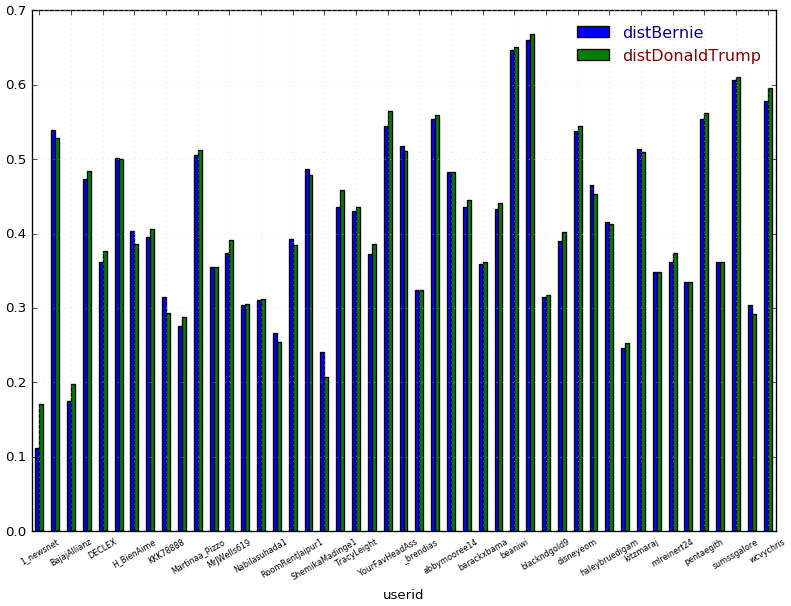

In [149]:
import numpy as np
from pyspark.sql.types import Row
def addEuclideanDistance(s):
    dict = s.asDict()
    def getEuclideanDistance(a,b):
        return np.linalg.norm(np.array(a) - np.array(b)).item()
    dict["distDonaldTrump"]=getEuclideanDistance(s[1:], broadCastTrumpPI.value)
    dict["distBernie"]=getEuclideanDistance(s[1:], broadCastBerniePI.value)
    dict["closerBernie"] = "Yes" if dict["distBernie"] < dict["distDonaldTrump"] else "No"
    return Row(**dict)

#add euclidean distances to Trump and Bernie
euclideanDF = sqlContext.createDataFrame(usersWithPIDF.map(lambda s: addEuclideanDistance(s)))

#Reorder columns to have userid and distances first
cols = euclideanDF.columns
reorderCols = ["userid","distBernie","distDonaldTrump", "closerBernie"]
euclideanDF = euclideanDF.select(reorderCols + [x for x in cols if x not in reorderCols])

#PixieDust display. 
#To visualize the distribution, select the bar chart display, use closerBernie as key and value and aggregation=count
display(euclideanDF)

## Begin Trump vs Bernie Sentiment Analysis

In [ ]:
import twitter, re, datetime, pandas as pd

class twitterminer():

    result_limit    =   20    
    api             =   False
    data            =   []
    
    twitter_keys = {
        'consumer_key':        'g0EXNI4DVJTxmlAKzMiqEGKgi',
        'consumer_secret':     'TSpkjqxGxuR9cLAh2h7CusVYxmJ5SG6eLE7f0RUs6MUUbcN6qT',
        'access_token_key':    '1599677424-SId5x6I6evEbraG3qFs8GuNzPqrzAnc4PbtjcKb',
        'access_token_secret': '369avxzU45YOF9cynXfpnd7ISQXOqXZnT9wYFyZtKZLhz'
    }
    
    def __init__(self,  result_limit = 20):
        
        self.result_limit = result_limit
        
        # This sets the twitter API object for use internall within the class
        self.set_api()
        
    def set_api(self):
        
        self.api = twitter.Api(
            consumer_key         =   self.twitter_keys['consumer_key'],
            consumer_secret      =   self.twitter_keys['consumer_secret'],
            access_token_key     =   self.twitter_keys['access_token_key'],
            access_token_secret  =   self.twitter_keys['access_token_secret']
        )

    def mine_user_tweets(self, user="Reem_Tahir", mine_rewteets=False, max_pages=5):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id - 1)        
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit)
                
            for item in statuses:

                mined = {
                    'tweet_id':        item.id,
                    'handle':          item.user.name,
                    'retweet_count':   item.retweet_count,
                    'text':            item.text,
                    'mined_at':        datetime.datetime.now(),
                    'created_at':      item.created_at,
                }
                
                last_tweet_id =   item.id
                data.append(mined)
                
            page          +=  1
            
        return data

## "Instantiate" a new instance of this class

In [ ]:
# twitter ids:  realDonaldTrump, berniesanders
# Let's test this out here..
# miner = twitterminer(request_limit = 2)
# reem = miner.mine_user_tweets(user="reem_says", max_pages=2)
# reem

miner = twitterminer(result_limit = 50)
bernie = miner.mine_user_tweets(user="Berniesanders", max_pages=5)
trump = miner.mine_user_tweets(user="realDonaldTrump", max_pages=5)

In [ ]:
df = pd.DataFrame(bernie)
df["tweet_id"].value_counts()

##  Now we create some training data

We will have to munge a little bit in order to get our "mined" data from the Twitter API.  

 - Mine Trump Tweets
 - Create DataFrame
 - Mine Sanders Tweets
 - Append to DataFrame

In [82]:
# we only need to "instantiate" once.  Then we can call mine_user_tweets as much as we want.
miner = twitterminer(result_limit=400)
trump_tweets = miner.mine_user_tweets("realDonaldTrump")

In [83]:
trump_df = pd.DataFrame(trump_tweets)
trump_df.head(10)

,created_at,handle,mined_at,retweet_count,text,tweet_id
0,Thu Feb 16 23:44:54 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564391,12201,'Trump signs bill undoing Obama coal mining ru...,832375230274400256
1,Thu Feb 16 14:39:52 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564407,22514,The Democrats had to come up with a story as t...,832238070460186625
2,Thu Feb 16 14:10:49 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564411,16597,"FAKE NEWS media, which makes up stories and ""s...",832230758299340800
3,Thu Feb 16 12:02:59 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564414,22581,The spotlight has finally been put on the low-...,832198588201594880
4,Thu Feb 16 11:58:43 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564418,15191,"Leaking, and even illegal classified leaking, ...",832197515248275456
5,Thu Feb 16 11:34:46 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564421,20988,Stock market hits new high with longest winnin...,832191485701451777
6,Wed Feb 15 23:59:26 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564425,49217,"Venezuela should allow Leopoldo Lopez, a polit...",832016501657968640
7,Wed Feb 15 21:34:05 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564428,13468,Aetna CEO: Obamacare in 'Death Spiral' #Repeal...,831979921555742732
8,Wed Feb 15 19:45:16 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564431,16654,Join me in Florida this Saturday at 5pm for a ...,831952535544070145
9,Wed Feb 15 19:17:59 +0000 2017,Donald J. Trump,2017-02-17 01:14:47.564434,13335,"Welcome to the United States, @IsraeliPM Benja...",831945670324060164


## Any interesting ngrams going on with Trump?

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# We can use the TfidfVectorizer to find ngrams for us
vect = TfidfVectorizer(ngram_range=(2,4))

# Pulls all of trumps tweet text's into one giant string
summaries = "".join(trump_df['text'])
ngrams_summaries = vect.build_analyzer()(summaries)

Counter(ngrams_summaries).most_common(20)

[(u'https co', 529),
 (u'will be', 73),
 (u'thank you', 68),
 (u'of the', 59),
 (u'in the', 49),
 (u'draintheswamp https co', 45),
 (u'draintheswamp https', 45),
 (u'we will', 41),
 (u'going to', 41),
 (u'make america', 35),
 (u'for the', 30),
 (u'it is', 30),
 (u'great again', 29),
 (u'our country', 27),
 (u'to the', 27),
 (u'get out', 26),
 (u'america great', 26),
 (u'america great again', 26),
 (u'make america great again', 25),
 (u'we are', 25)]

In [85]:
bernie_tweets = miner.mine_user_tweets("berniesanders")
bernie_df = pd.DataFrame(bernie_tweets)
bernie_df.head(10)

,created_at,handle,mined_at,retweet_count,text,tweet_id
0,Thu Feb 16 16:43:00 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356248,6147,Scientists are virtually unanimous that climat...,832269058254925824
1,Thu Feb 16 14:18:56 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356270,487,RT @GoodJobsNation: . @BernieSanders : Our job...,832232802670231552
2,Thu Feb 16 02:22:15 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356274,1117,RT @ABCPolitics: .@BernieSanders calls Puzder'...,832052443403919361
3,Wed Feb 15 20:28:52 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356277,4038,We need a Labor Secretary who will stand up fo...,831963509013540865
4,Wed Feb 15 17:12:06 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356281,10914,We need to know if President Trump's foreign p...,831913992373288961
5,Mon Feb 13 23:47:00 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356285,2997,Our job: Break up the major financial institut...,831288596778905600
6,Mon Feb 13 22:22:01 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356288,2634,Our job is to grow the trade union movement so...,831267207321645060
7,Mon Feb 13 20:59:01 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356291,1483,Trump old workers he would stand up for them a...,831246321705222145
8,Mon Feb 13 19:39:02 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356294,4799,What I say to the American people is: stay foc...,831226191818399744
9,Sun Feb 12 22:01:01 +0000 2017,Bernie Sanders,2017-02-17 01:15:50.356297,3458,We’ve got to bring people together around a pr...,830899534830170112


In [86]:
# We can use the TfidfVectorizer to find ngrams for us
vect = TfidfVectorizer(ngram_range=(2,4))

# Pulls all of trumps tweet text's into one giant string
summaries = "".join(bernie_df['text'])
ngrams_summaries = vect.build_analyzer()(summaries)

Counter(ngrams_summaries).most_common(20)

[(u'https co', 416),
 (u'of the', 75),
 (u'donald trump', 62),
 (u'in the', 59),
 (u'health care', 53),
 (u'going to', 52),
 (u'for the', 48),
 (u'we must', 46),
 (u'we need', 41),
 (u'we are', 41),
 (u'to the', 36),
 (u'bernie sanders', 35),
 (u'on the', 34),
 (u'this country', 31),
 (u'is the', 30),
 (u'should be', 30),
 (u'stand up', 30),
 (u'millions of', 30),
 (u'want to', 29),
 (u'climate change', 27)]

In [87]:
all_tweets = pd.DataFrame(trump_tweets + bernie_tweets)
all_tweets.handle.value_counts()
# all_tweets.groupby("handle").size()

Donald J. Trump    1000
Bernie Sanders     1000
Name: handle, dtype: int64

## Preprocessing our Tweets

In order to do classfication recall that we need a set of features.  Our features are literally what our presidential hopefulls say on Twitter. 

We will need to:
- Vectorize input text data
- Intialize a model (let's try Logistic regression)
- Train / Predict / Cross Validate
- Score / Evaluate


## Check Prediction vs Random Sanders Tweet

In [103]:
estimator.score(X_test, y_test)

0.91000000000000003

In [104]:
from sklearn.metrics import classification_report, confusion_matrix

print classification_report(y_test, predictions)

             precision    recall  f1-score   support

Bernie Sanders       0.93      0.90      0.92       270
Donald J. Trump       0.89      0.92      0.90       230

avg / total       0.91      0.91      0.91       500



In [105]:
miner.api.GetSearch()

[]

In [106]:
# Confusion Matrix
print confusion_matrix(y_test, predictions)

[[244  26]
 [ 19 211]]
